# Importar y configuración inicial

In [20]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import VGG16
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
import os
from tensorflow.keras.preprocessing import image


# Parámetros globales
IMG_SIZE = 300
BATCH_SIZE = 32
EPOCHS_CUSTOM = 5
EPOCHS_VGG_BASE = 3
EPOCHS_VGG_FT = 5

In [21]:
(ds_train, ds_test), ds_info = tfds.load(
    'horses_or_humans',
    split=['train', 'test'],
    with_info=True,
    as_supervised=True
)
print(ds_info)

tfds.core.DatasetInfo(
    name='horses_or_humans',
    full_name='horses_or_humans/3.0.0',
    description="""
    A large set of images of horses and humans.
    """,
    homepage='http://laurencemoroney.com/horses-or-humans-dataset',
    data_dir='C:\\Users\\jorge\\tensorflow_datasets\\horses_or_humans\\3.0.0',
    file_format=tfrecord,
    download_size=153.59 MiB,
    dataset_size=153.53 MiB,
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    nondeterministic_order=False,
    splits={
        'test': <SplitInfo num_examples=256, num_shards=1>,
        'train': <SplitInfo num_examples=1027, num_shards=2>,
    },
    citation="""@ONLINE {horses_or_humans,
    author = "Laurence Moroney",
    title = "Horses or Humans Dataset",
    month = "feb",
    year = "2019",
    url = "http://laurencemoroney.com/h

# Preprocesamiento y data augmentation


In [22]:
# Preprocesamiento común: resize y normalización
def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image/255.0, label

# Augmentación en tf.data
@tf.function
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    return image, label

# Pipeline de entrenamiento
ds_train = ds_train.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
ds1 = ds_train.shuffle(1000)
ds_train = ds1.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Pipeline de test
ds_test = ds_test.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

Aqui hemos hecho: 
- RESIZE: lo he utilizado para redimensionar las imágenes
- Normalización: escala los valores de los píxeles de [0,255] a binario [0,1]. 

- FLIP: se utiliza para generar variabilidad en la posición de las imágenes. 
- CAMBIAR BRILLO: ajustamos el valor del brillo a un valor cercano a 0.2
- CAMBIAR CONTRASTE: ajustamos el valor del contraste a un valor entre 0.8 y 1.2

* Entrenamiento: se normaliza y redimensiona, luego se mezclan las imágenes del dataset y luego se aplican las transformaciones aleatorias, agrupa y usamos prefetch para que tire del a GPU. 
* Validación/test: redimensiona y normaliza, agrupa los batches y los prefetch



# Cálculo de pesos de clases

In [23]:
# Cargar solo split 'train' original para extraer etiquetas
ds_train_orig = tfds.load('horses_or_humans', split='train', as_supervised=True)
labels = ds_train_orig.map(lambda img, lbl: lbl)
y_all = np.concatenate([lbl.numpy() for lbl in labels.batch(10000)])

# Pesos balanceados
nweights = class_weight.compute_class_weight('balanced', classes=np.unique(y_all), y=y_all)
class_weights = dict(enumerate(nweights))
print('Class weights:', class_weights)

Class weights: {0: 1.027, 1: 0.9743833017077799}


En esta parte se verifica los pesos para que compensar los posibles desequilibrios.

# Definición de modelos
Modelo 1:CNN personalizada regularizado

In [24]:
model_custom = models.Sequential([
    layers.Input((IMG_SIZE, IMG_SIZE, 3)),
    layers.Conv2D(32, 3, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])
model_custom.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Modelo 2: Transfer learning con VGG16 base


In [25]:
base_model = VGG16(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')
base_model.trainable = False

model_vgg_base = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])
model_vgg_base.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenamiento y evaluación de los modelos

In [26]:
# 1) Modelo personalizado
print('Entrenando CNN personalizada:')
history_custom = model_custom.fit(
    ds_train,
    validation_data=ds_test,
    epochs=EPOCHS_CUSTOM,
    class_weight=class_weights
)

# 2) VGG16 base
print('Entrenando VGG16 base:')
history_vgg_base = model_vgg_base.fit(
    ds_train,
    validation_data=ds_test,
    epochs=EPOCHS_VGG_BASE,
    class_weight=class_weights
)

# 3) Fine-tuning de VGG16
print('Fine-tuning de VGG16:')
for layer in base_model.layers[-4:]:
    layer.trainable = True

model_vgg_ft = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])
model_vgg_ft.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])

print('Entrenando VGG16 fine-tuning:')
history_vgg_ft = model_vgg_ft.fit(
    ds_train,
    validation_data=ds_test,
    epochs=EPOCHS_VGG_FT,
    class_weight=class_weights
)

Entrenando CNN personalizada:
Epoch 1/5


33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 683ms/step - accuracy: 0.6191 - loss: 1.6578 - val_accuracy: 0.6914 - val_loss: 1.7155
Epoch 2/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 23s 679ms/step - accuracy: 0.9478 - loss: 0.2003 - val_accuracy: 0.7305 - val_loss: 1.6975
Epoch 3/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 23s 693ms/step - accuracy: 0.9066 - loss: 0.2940 - val_accuracy: 0.6875 - val_loss: 2.1570
Epoch 4/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 23s 705ms/step - accuracy: 0.9747 - loss: 0.1307 - val_accuracy: 0.7227 - val_loss: 3.9774
Epoch 5/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 24s 714ms/step - accuracy: 0.9731 - loss: 0.1333 - val_accuracy: 0.7344 - val_loss: 2.6022
Entrenando VGG16 base:
Epoch 1/3
33/33 ━━━━━━━━━━━━━━━━━━━━ 170s 5s/step - accuracy: 0.7241 - loss: 2.0430 - val_accuracy: 0.9258 - val_loss: 0.2828
Epoch 2/3
33/33 ━━━━━━━━━━━━━━━━━━━━ 176s 5s/step - accuracy: 0.9857 - loss: 0.0430 - val_accuracy: 0.9453 - val_loss: 0.1491
Epoch 3/3
33/33 ━━━━━━━━━━━━━━━━━━━━ 179s 5s/step - accuracy: 0.9969 - loss: 0.0083 - val_accur

Métricas de rendimiento

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
--- CNN personalizada ---
              precision    recall  f1-score   support

       horse       1.00      0.47      0.64       128
       human       0.65      1.00      0.79       128

    accuracy                           0.73       256
   macro avg       0.83      0.73      0.71       256
weighted avg       0.83      0.73      0.71       256

Matriz de confusión:
 [[ 60  68]
 [  0 128]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
--

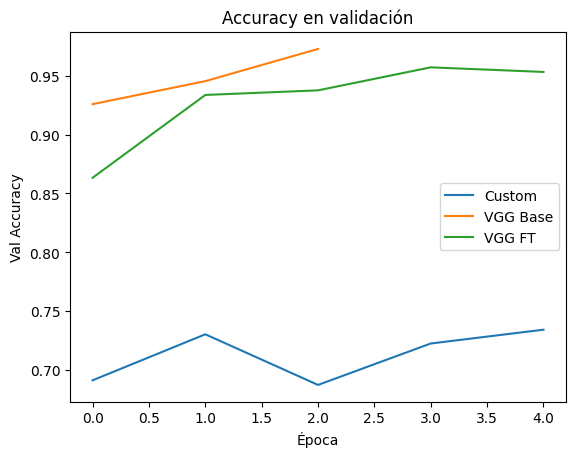

In [27]:
# Función de evaluación
def evaluate(model, dataset, name):
    y_true, y_pred = [], []
    for imgs, lbls in dataset:
        preds = (model.predict(imgs) > 0.5).astype(int).flatten()
        y_true.extend(lbls.numpy())
        y_pred.extend(preds.tolist())
    print(f"--- {name} ---")
    print(classification_report(y_true, y_pred, target_names=['horse','human']))
    print('Matriz de confusión:\n', confusion_matrix(y_true, y_pred))

# Reporte
evaluate(model_custom, ds_test, 'CNN personalizada')
evaluate(model_vgg_base, ds_test, 'VGG16 base')
evaluate(model_vgg_ft, ds_test, 'VGG16 fine-tuning')

# Gráficas comparativas
plt.figure()
for hist, label in [(history_custom, 'Custom'), (history_vgg_base, 'VGG Base'), (history_vgg_ft, 'VGG FT')]:
    plt.plot(hist.history['val_accuracy'], label=label)
plt.title('Accuracy en validación')
plt.xlabel('Época')
plt.ylabel('Val Accuracy')
plt.legend()
plt.show()

# Prueba con imágenes externas

Sin ajustes

In [28]:
def predict_external(model, folder, name):
    print(f"Predicciones {name}:")
    for f in os.listdir(folder):
        img = image.load_img(os.path.join(folder, f), target_size=(IMG_SIZE, IMG_SIZE))
        x = np.expand_dims(img, 0)/255.0
        pred = model.predict(x)[0][0]
        label = 'human' if pred>0.5 else 'horse'
        print(f"{f}: {label} (prob={pred:.2f})")

predict_external(model_custom, 'ext_images', 'Custom')
predict_external(model_vgg_ft, 'ext_images', 'VGG FT')

Predicciones Custom:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
image_1.jpeg: horse (prob=0.22)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
image_10.jpeg: horse (prob=0.00)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
image_11.jpeg: horse (prob=0.00)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
image_12.jpeg: horse (prob=0.03)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
image_13.jpeg: horse (prob=0.00)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
image_14.jpeg: horse (prob=0.00)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
image_15.jpeg: horse (prob=0.00)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
image_16.jpeg: human (prob=0.99)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
image_17.jpeg: horse (prob=0.32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
image_18.jpeg: horse (prob=0.00)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
image_19.jpeg: horse (prob=0.47)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
image_2.jpeg: human (prob=1.00)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
image_20.jpeg: human (prob=1.00)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
image_3.jpeg: horse

Con ajustes de umbral

In [30]:
def predict_external(model, folder, name, threshold=0.5):
    print(f"Predicciones {name} (umbral={threshold}):")
    for f in os.listdir(folder):
        img_path = os.path.join(folder, f)
        img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
        x = np.expand_dims(img, 0) / 255.0
        prob = model.predict(x)[0][0]
        label = 'horse' if prob < threshold else 'human'
        print(f"{f}: {label} (prob={prob:.2f})")

# Clasificación con umbral estándar
predict_external(model_custom, 'ext_images', 'Custom', threshold=0.5)
predict_external(model_vgg_ft, 'ext_images', 'VGG FT', threshold=0.5)

print("-- Ajuste de umbral para mejorar recall de caballos --")
predict_external(model_custom, 'ext_images', 'Custom', threshold=0.8)
predict_external(model_vgg_ft, 'ext_images', 'VGG FT', threshold=0.8)

Predicciones Custom (umbral=0.5):
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
image_1.jpeg: horse (prob=0.22)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
image_10.jpeg: horse (prob=0.00)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
image_11.jpeg: horse (prob=0.00)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
image_12.jpeg: horse (prob=0.03)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
image_13.jpeg: horse (prob=0.00)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
image_14.jpeg: horse (prob=0.00)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
image_15.jpeg: horse (prob=0.00)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
image_16.jpeg: human (prob=0.99)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
image_17.jpeg: horse (prob=0.32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
image_18.jpeg: horse (prob=0.00)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
image_19.jpeg: horse (prob=0.47)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
image_2.jpeg: human (prob=1.00)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
image_20.jpeg: human (prob=1.00)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
image_